# Задание 3

In [2]:
!pip install -q catalyst

     |████████████████████████████████| 543 kB 5.2 MB/s 
     |████████████████████████████████| 636 kB 38.8 MB/s 
     |████████████████████████████████| 120 kB 48.7 MB/s 


In [55]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)

import matplotlib.pyplot as plt
%matplotlib inline

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [4]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features, requires_grad=True))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.zeros(1, out_features, requires_grad=True))

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [5]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

In [6]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [8]:
X_train_t =  torch.Tensor(X_train)
y_train_t =  torch.Tensor(y_train)
X_val_t =  torch.Tensor(X_val)
y_val_t =  torch.Tensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [9]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [10]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [11]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(linear_regression)

3

**Вопрос 1** Сколько обучаемых параметров у получившейся модели?

**Ответ:** 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [12]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        outp = outp.view(outp.shape[0])
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.6484375
Iteration: 7500
Batch accuracy: 0.734375
Iteration: 15000
Batch accuracy: 0.78125
Iteration: 22500
Batch accuracy: 0.7890625
Iteration: 30000
Batch accuracy: 0.8046875
Iteration: 37500
Batch accuracy: 0.8046875
Iteration: 45000
Batch accuracy: 0.8046875
Iteration: 52500
Batch accuracy: 0.8046875
Iteration: 60000
Batch accuracy: 0.8203125
Iteration: 67500
Batch accuracy: 0.8203125
Iteration: 75000
Batch accuracy: 0.8203125
Iteration: 82500
Batch accuracy: 0.8203125
Iteration: 90000
Batch accuracy: 0.8203125

Iteration: 90051.Convergence. Stopping iterations.


**Вопрос 2**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 90051

### Визуализируем результаты

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [14]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [15]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [16]:
from sklearn.metrics import accuracy_score


accuracy_score(predict(val_dataloader ,linear_regression), y_val_t)

0.862

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

### MNIST

In [27]:
import os
from catalyst.contrib.datasets import MNIST

train_dataset = MNIST(root=os.getcwd(), train=True, download=True)
val_dataset = MNIST(root=os.getcwd(), train=False)
train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

In [18]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [47]:
activation = nn.LeakyReLU

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [49]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch.to(torch.float32))
                 loss = criterion(outp, y_batch)
                 loss.backward()
                 optimizer.step()
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch.to(torch.float32))
            preds = outp.argmax(-1)
            correct =  sum(preds == y_batch)
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9002666666666667
Loader: valid. Accuracy: 0.9061714285714285
Epoch: 2
Loader: train. Accuracy: 0.9562166666666667
Loader: valid. Accuracy: 0.9533714285714285
Epoch: 3
Loader: train. Accuracy: 0.96555
Loader: valid. Accuracy: 0.9621142857142857
Epoch: 4
Loader: train. Accuracy: 0.9707833333333333
Loader: valid. Accuracy: 0.9671571428571428
Epoch: 5
Loader: train. Accuracy: 0.97235
Loader: valid. Accuracy: 0.9699
Epoch: 6
Loader: train. Accuracy: 0.9747333333333333
Loader: valid. Accuracy: 0.9723428571428572
Epoch: 7
Loader: train. Accuracy: 0.9785833333333334
Loader: valid. Accuracy: 0.976
Epoch: 8
Loader: train. Accuracy: 0.9785166666666667
Loader: valid. Accuracy: 0.9772285714285714
Epoch: 9
Loader: train. Accuracy: 0.98335
Loader: valid. Accuracy: 0.9807142857142858
Epoch: 10
Loader: train. Accuracy: 0.9810166666666666
Loader: valid. Accuracy: 0.9791571428571428


Попробуйте разные функции активации. Позапускайте ячейки сверху несколько раз изменив функции активации. После каждого обучения запустите одну из ячеек снизу. Таким образом мы получим график accuracy/epoch для каждой функции активации.

In [46]:
plain_accuracy = accuracy["valid"]

In [42]:
relu_accuracy = accuracy["valid"]

In [50]:
leaky_relu_accuracy = accuracy["valid"]

In [37]:
elu_accuracy = accuracy["valid"]

### Accuracy

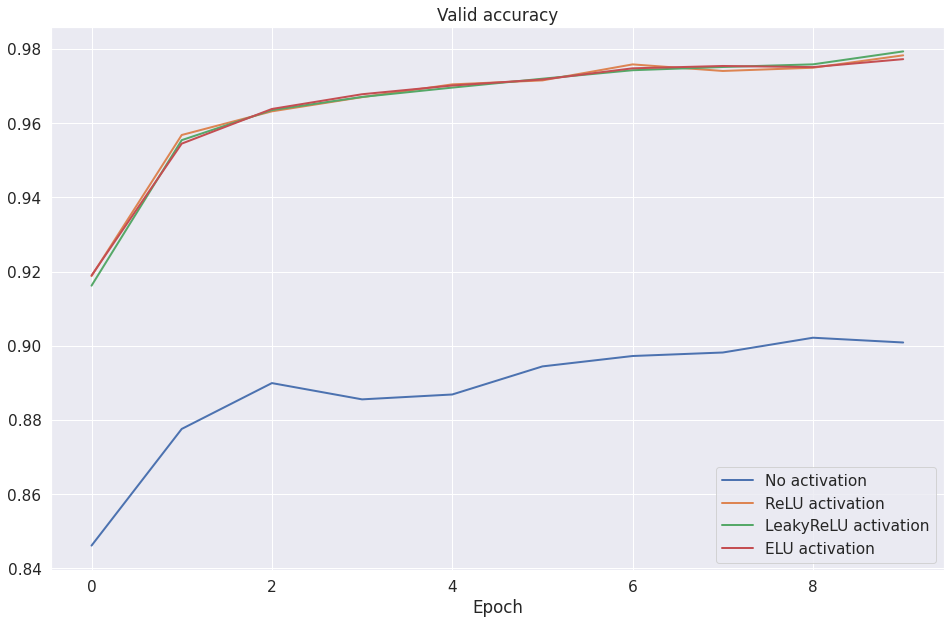

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

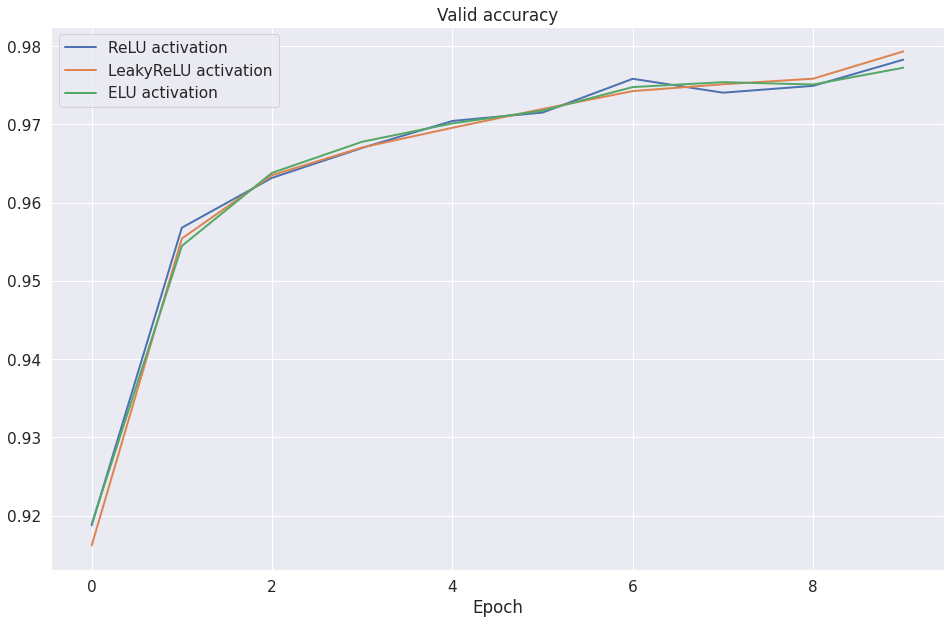

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4** Какая из активаций показала наивысший `accuracy`?

**Ответ:** ReLU

## Сверточные слои

### Ядра

In [51]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-08-07 14:37:45--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-08-07 14:37:46--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   240KB/s    in 0.2s    

2021-08-07 14:37:46 (240 KB/s) - ‘sample_photo.jpg’ saved [49337/4

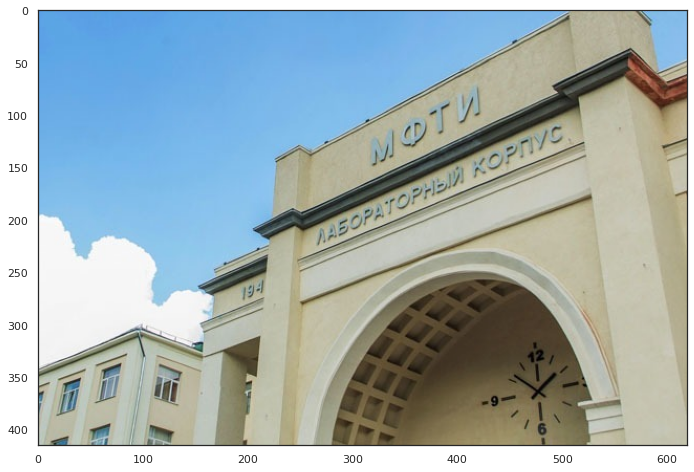

In [56]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [67]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

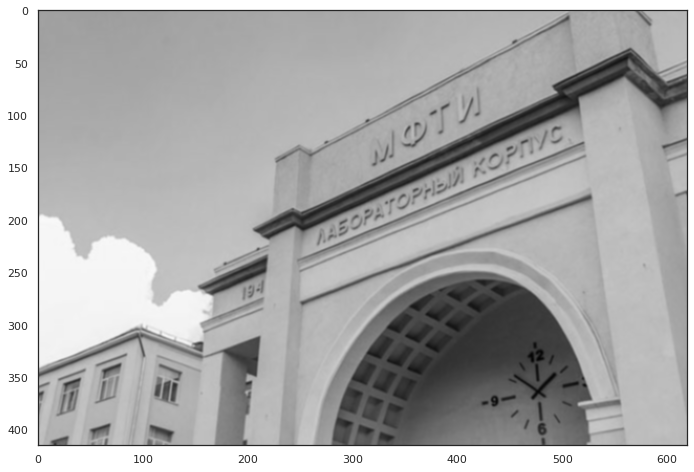

In [68]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5** Как вы считаете, как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Давайте посмотрим на архитектуру, предложенную еще в 1998 году!

In [72]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [73]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [75]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42+epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch[:, np.newaxis].type(torch.float32))
                 loss = criterion(outp, y_batch)
                 loss.backward()
                 optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.type(torch.float32).unsqueeze(1))
            preds = outp.argmax(-1)
            correct =  sum(preds == y_batch)
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1
Loader: train. Accuracy: 0.9284666666666667
Loader: valid. Accuracy: 0.9340571428571428
Epoch: 2
Loader: train. Accuracy: 0.9760333333333333
Loader: valid. Accuracy: 0.9755142857142857
Epoch: 3
Loader: train. Accuracy: 0.9822666666666666
Loader: valid. Accuracy: 0.9813428571428572
Epoch: 4
Loader: train. Accuracy: 0.9864166666666667
Loader: valid. Accuracy: 0.9855857142857143
Epoch: 5
Loader: train. Accuracy: 0.9880666666666666
Loader: valid. Accuracy: 0.9868142857142858
Epoch: 6
Loader: train. Accuracy: 0.9902833333333333
Loader: valid. Accuracy: 0.9888714285714286
Epoch: 7
Loader: train. Accuracy: 0.9914666666666667
Loader: valid. Accuracy: 0.9902571428571428
Epoch: 8
Loader: train. Accuracy: 0.9911666666666666
Loader: valid. Accuracy: 0.9901142857142857
Epoch: 9
Loader: train. Accuracy: 0.9926666666666667
Loader: valid. Accuracy: 0.9911428571428571
Epoch: 10
Loader: train. Accuracy: 0.9935666666666667
Loader: valid. Accuracy: 0.9925857142857143


In [76]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

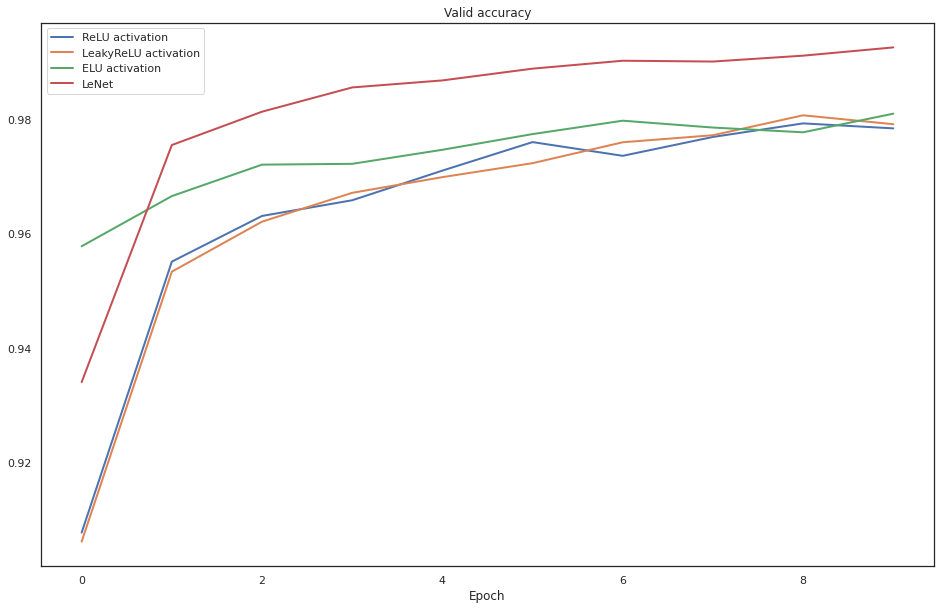

In [78]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99